# Proyek Klasifikasi Gambar: Multi-Class Weather Dataset 

https://www.kaggle.com/datasets/pratik2901/multiclass-weather-dataset
- **Nama:** Muhammad Fatih Al Fawwaz
- **Email:** fatihfwz87@gmail.com
- **ID Dicoding:** fatihfwz

## 1. Import Libraries

Mengimport library yang diperlukan untuk preprocessing data, membangun model, dan visualisasi.

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import json
import shutil
import seaborn as sns
import tensorflowjs as tfjs

import warnings
warnings.filterwarnings('ignore')

## 2. Load Dataset

Membaca semua gambar dari folder dataset dan membuat list yang berisi path gambar beserta labelnya.

In [6]:
dataset_path = '/kaggle/input/multiclass-weather-dataset/Multi-class Weather Dataset'
classes = ['Cloudy', 'Rain', 'Shine', 'Sunrise']
class_to_idx = {cls: idx for idx, cls in enumerate(classes)}

images = []
labels = []

for cls in classes:
    cls_path = os.path.join(dataset_path, cls)
    for img_name in os.listdir(cls_path):
        img_path = os.path.join(cls_path, img_name)
        images.append(img_path)
        labels.append(class_to_idx[cls])

print(f'Total images: {len(images)}')
for cls in classes:
    count = sum(1 for label in labels if label == class_to_idx[cls])
    print(f'{cls}: {count} images')

Total images: 1125
Cloudy: 300 images
Rain: 215 images
Shine: 253 images
Sunrise: 357 images


## 3. Resize & Normalize Images

Membaca dan mengubah ukuran semua gambar menjadi 150x150 pixel, kemudian menormalisasi nilai piksel ke range [0, 1].

In [7]:
IMG_SIZE = 150
X = []

for img_path in images:
    try:
        img = Image.open(img_path).convert('RGB')
        img = img.resize((IMG_SIZE, IMG_SIZE))
        X.append(np.array(img) / 255.0)
    except:
        pass

X = np.array(X[:len(images)])
y = np.array(labels[:len(X)])

print(f'X shape: {X.shape}')
print(f'y shape: {y.shape}')

X shape: (1125, 150, 150, 3)
y shape: (1125,)


## 4. Train-Test-Validation Split

Membagi dataset menjadi 70% training, 15% testing, dan 15% validation set.

In [8]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

print(f'Train: {X_train.shape[0]}')
print(f'Test: {X_test.shape[0]}')
print(f'Validation: {X_val.shape[0]}')

Train: 787
Test: 169
Validation: 169


## 5. One-Hot Encoding Labels

Mengkonversi label numerik menjadi one-hot encoding untuk model klasifikasi multi-kelas.

In [9]:
from tensorflow.keras.utils import to_categorical

y_train_cat = to_categorical(y_train, num_classes=4)
y_test_cat = to_categorical(y_test, num_classes=4)
y_val_cat = to_categorical(y_val, num_classes=4)

print(f'y_train shape: {y_train_cat.shape}')
print(f'y_test shape: {y_test_cat.shape}')
print(f'y_val shape: {y_val_cat.shape}')

y_train shape: (787, 4)
y_test shape: (169, 4)
y_val shape: (169, 4)


## 6. Data Augmentation Setup

Menerapkan augmentasi data dengan rotasi, shift, zoom, dan flip untuk meningkatkan generalisasi model.

In [10]:
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_datagen.fit(X_train)
print('Data augmentation ready')

Data augmentation ready


## 7. Build CNN Model

Membangun arsitektur Sequential CNN dengan Conv2D, MaxPooling2D, Dense layers, dan Dropout untuk regularisasi.

In [11]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(4, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

I0000 00:00:1764738961.050032      47 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     9,470,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,564,484 (36.49 MB)

 Trainable params: 9,564,484 (36.49 MB)

 Non-trainable params: 0 (0.00 B)

## 8. Train Model with Augmentation

Melatih model menggunakan augmented data untuk meningkatkan generalisasi selama 50 epoch.

In [12]:
history = model.fit(
    train_datagen.flow(X_train, y_train_cat, batch_size=32),
    epochs=50,
    validation_data=(X_val, y_val_cat),
    steps_per_epoch=len(X_train)//32,
    verbose=1
)

Epoch 1/50


I0000 00:00:1764738974.378543     106 service.cc:148] XLA service 0x7a4c580048a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1764738974.379251     106 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1764738974.667226     106 cuda_dnn.cc:529] Loaded cuDNN version 90300


 3/24 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - accuracy: 0.2413 - loss: 2.1844

I0000 00:00:1764738977.683892     106 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


24/24 ━━━━━━━━━━━━━━━━━━━━ 11s 283ms/step - accuracy: 0.4441 - loss: 1.4600 - val_accuracy: 0.5207 - val_loss: 0.8683
Epoch 2/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5938 - loss: 0.7266 - val_accuracy: 0.6686 - val_loss: 0.8166
Epoch 3/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 144ms/step - accuracy: 0.6743 - loss: 0.7918 - val_accuracy: 0.8402 - val_loss: 0.6640
Epoch 4/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9062 - loss: 0.4542 - val_accuracy: 0.8047 - val_loss: 0.8068
Epoch 5/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 143ms/step - accuracy: 0.7701 - loss: 0.5881 - val_accuracy: 0.8698 - val_loss: 0.4758
Epoch 6/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7812 - loss: 0.4990 - val_accuracy: 0.8639 - val_loss: 0.4950
Epoch 7/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 142ms/step - accuracy: 0.8080 - loss: 0.4985 - val_accuracy: 0.8462 - val_loss: 0.4784
Epoch 8/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9062 - loss: 0.4040 - val_accuracy: 0.8402 - val_loss: 0

## 9. Evaluate Model

Mengevaluasi performa model pada training dan test set dengan menampilkan akurasi serta loss.

In [13]:
test_loss, test_accuracy = model.evaluate(X_test, y_test_cat)
train_loss, train_accuracy = model.evaluate(X_train, y_train_cat)

print(f'\nTrain Accuracy: {train_accuracy * 100:.2f}%')
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9386 - loss: 0.1774 
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.9439 - loss: 0.1475

Train Accuracy: 93.52%
Test Accuracy: 92.90%


## 10. Plot Training History

Memvisualisasikan akurasi dan loss selama proses training untuk melihat performa model.

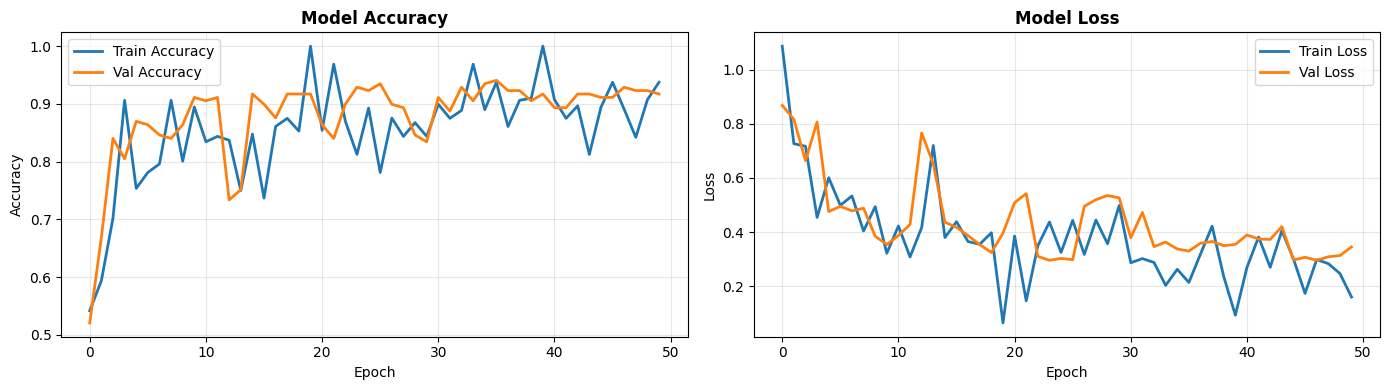

Training history plot saved


In [14]:
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

axes[0].plot(history.history['accuracy'], label='Train Accuracy', linewidth=2)
axes[0].plot(history.history['val_accuracy'], label='Val Accuracy', linewidth=2)
axes[0].set_title('Model Accuracy', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(history.history['loss'], label='Train Loss', linewidth=2)
axes[1].plot(history.history['val_loss'], label='Val Loss', linewidth=2)
axes[1].set_title('Model Loss', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training_history.png', dpi=150, bbox_inches='tight')
plt.show()
print('Training history plot saved')

## 11. Confusion Matrix & Classification Report

Menampilkan confusion matrix dan classification report untuk analisis detail performa model per kelas.

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step


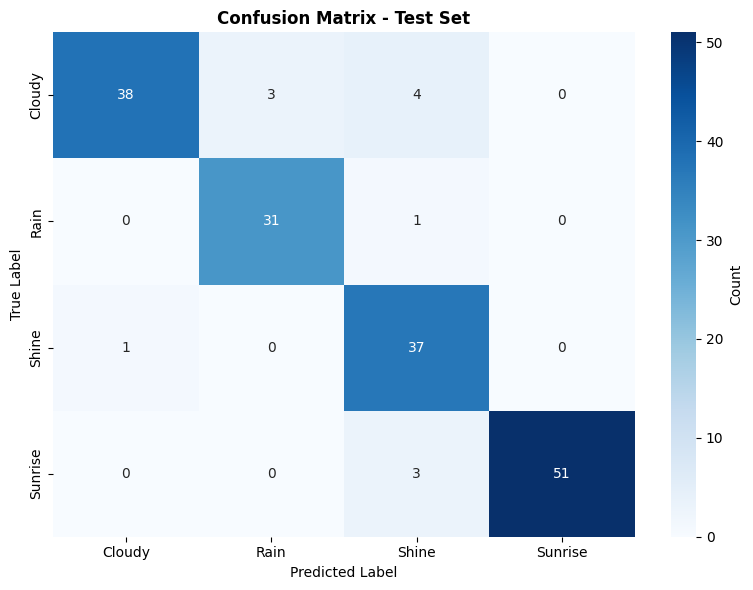


Classification Report:
              precision    recall  f1-score   support

      Cloudy       0.97      0.84      0.90        45
        Rain       0.91      0.97      0.94        32
       Shine       0.82      0.97      0.89        38
     Sunrise       1.00      0.94      0.97        54

    accuracy                           0.93       169
   macro avg       0.93      0.93      0.93       169
weighted avg       0.94      0.93      0.93       169



In [15]:
y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)

cm = confusion_matrix(y_test, y_pred_labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes, cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix - Test Set', fontsize=12, fontweight='bold')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nClassification Report:")
print(classification_report(y_test, y_pred_labels, target_names=classes))

## 14. Save SavedModel Format

Menyimpan model dalam format SavedModel untuk deployment di server atau cloud.

In [28]:
output_dir = '/kaggle/working/model'
os.makedirs(output_dir, exist_ok=True)

saved_model_path = os.path.join(output_dir, 'saved_model')
model.export(saved_model_path)
print(f'SavedModel exported at {saved_model_path}')

keras_path = os.path.join(output_dir, 'model.keras')
model.save(keras_path)
print(f'Keras model saved at {keras_path}')

INFO:tensorflow:Assets written to: /kaggle/working/model/saved_model/assets


INFO:tensorflow:Assets written to: /kaggle/working/model/saved_model/assets


Saved artifact at '/kaggle/working/model/saved_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)
Captures:
  134472495071888: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134472495072656: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134472495074000: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134472495071696: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134472495073424: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134472495074768: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134472495072080: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134472495075152: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134472495075536: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134472495077072: TensorSpec(shape=(), dtype=tf.resource, name=None)

## 15. Inference using SavedModel

Demonstrasi melakukan inference menggunakan model yang sudah disimpan dalam format SavedModel.

In [32]:
keras_model = load_model(keras_path)

test_samples_idx = [0, 5, 10, 15]
print("\n=== SAVEDMODEL INFERENCE (using .keras format) ===")
for idx in test_samples_idx:
    test_sample = np.expand_dims(X_test[idx], axis=0)
    keras_pred = keras_model.predict(test_sample, verbose=0)
    print(f"Sample {idx}: True={classes[y_test[idx]]}, Pred={classes[np.argmax(keras_pred)]}, Conf={np.max(keras_pred)*100:.2f}%")

print("\n=== SAVEDMODEL INFERENCE (using SavedModel format) ===")
concrete_func = tf.saved_model.load(saved_model_path).signatures['serving_default']
for idx in test_samples_idx:
    test_sample = tf.convert_to_tensor(np.expand_dims(X_test[idx], axis=0), dtype=tf.float32)
    output = concrete_func(test_sample)
    output_key = list(output.keys())[0]
    saved_pred = output[output_key].numpy()
    print(f"Sample {idx}: True={classes[y_test[idx]]}, Pred={classes[np.argmax(saved_pred)]}, Conf={np.max(saved_pred)*100:.2f}%")


=== SAVEDMODEL INFERENCE (using .keras format) ===
Sample 0: True=Cloudy, Pred=Cloudy, Conf=59.08%
Sample 5: True=Shine, Pred=Shine, Conf=94.02%
Sample 10: True=Cloudy, Pred=Cloudy, Conf=99.44%
Sample 15: True=Sunrise, Pred=Sunrise, Conf=100.00%

=== SAVEDMODEL INFERENCE (using SavedModel format) ===
Sample 0: True=Cloudy, Pred=Cloudy, Conf=59.08%
Sample 5: True=Shine, Pred=Shine, Conf=94.02%
Sample 10: True=Cloudy, Pred=Cloudy, Conf=99.44%
Sample 15: True=Sunrise, Pred=Sunrise, Conf=100.00%


## 16. Save TF-Lite Format

Mengkonversi model ke format TF-Lite untuk deployment di perangkat mobile dan embedded.

In [33]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

os.makedirs(os.path.join(output_dir, 'tflite'), exist_ok=True)
tflite_path = os.path.join(output_dir, 'tflite', 'model.tflite')
with open(tflite_path, 'wb') as f:
    f.write(tflite_model)

print(f'TF-Lite model saved at {tflite_path}')

INFO:tensorflow:Assets written to: /tmp/tmp5ypg5ag9/assets


INFO:tensorflow:Assets written to: /tmp/tmp5ypg5ag9/assets


Saved artifact at '/tmp/tmp5ypg5ag9'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)
Captures:
  134472495071888: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134472495072656: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134472495074000: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134472495071696: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134472495073424: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134472495074768: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134472495072080: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134472495075152: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134472495075536: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134472495077072: TensorSpec(shape=(), dtype=tf.resource, name=None)


W0000 00:00:1764739472.613053      47 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1764739472.613078      47 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.


TF-Lite model saved at /kaggle/working/model/tflite/model.tflite


## 17. Inference using TF-Lite

Demonstrasi melakukan inference menggunakan model yang dikonversi ke format TF-Lite untuk mobile/embedded.

In [34]:
interpreter = tf.lite.Interpreter(model_path=tflite_path)
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

print("\n=== TF-LITE INFERENCE ===")
for idx in test_samples_idx:
    test_img = X_test[idx].astype(np.float32)
    interpreter.set_tensor(input_details[0]['index'], np.expand_dims(test_img, axis=0))
    interpreter.invoke()
    tflite_pred = interpreter.get_tensor(output_details[0]['index'])
    print(f"Sample {idx}: True={classes[y_test[idx]]}, Pred={classes[np.argmax(tflite_pred)]}, Conf={np.max(tflite_pred)*100:.2f}%")


=== TF-LITE INFERENCE ===
Sample 0: True=Cloudy, Pred=Cloudy, Conf=59.08%
Sample 5: True=Shine, Pred=Shine, Conf=94.02%
Sample 10: True=Cloudy, Pred=Cloudy, Conf=99.44%
Sample 15: True=Sunrise, Pred=Sunrise, Conf=100.00%


## 18. Save Label File & TFJS

Menyimpan label kelas dan mengkonversi model ke format TFJS untuk deployment di browser.

In [ ]:
labels_path = os.path.join(output_dir, 'tflite', 'label.txt')
with open(labels_path, 'w') as f:
    for cls in classes:
        f.write(cls + '\n')

os.makedirs(os.path.join(output_dir, 'tfjs_model'), exist_ok=True)

tfjs_path = os.path.join(output_dir, 'tfjs_model')
tfjs.converters.save_keras_model(model, tfjs_path)
print('TFJS model converted successfully')

failed to lookup keras version from the file,
    this is likely a weight only file
TFJS model converted successfully
